In [1]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
from numpy import genfromtxt

#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
plt.style.use('default')

#  Generate Data


## Training/Testing Data 

#### Create Data (Affine Transformation)

In [4]:
my_data1 = genfromtxt('data1.csv', delimiter=',')
my_data2 = genfromtxt('data2.csv', delimiter=',')
my_data3 = genfromtxt('data3.csv', delimiter=',')
my_data4 = genfromtxt('data4.csv', delimiter=',')
my_data5 = genfromtxt('data5.csv', delimiter=',')
my_data6 = genfromtxt('data6.csv', delimiter=',')

In [5]:
#x = np.concatenate((my_data1[1:,2:8],my_data2[1:,2:8],my_data3[1:,2:8],my_data4[1:,2:8]))*np.pi/180
#y = np.concatenate((my_data1[1:,8:],my_data2[1:,8:],my_data3[1:,8:],my_data4[1:,8:]))
x = my_data6[0:, 0:6]
y = my_data6[0:, 6:]
num_pts = x.shape[0]

#### Training Mini-Batch Generator

In [6]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]

batch_size = int(0.8 * num_pts)
batch = Batch(x, y, batch_size)

In [7]:
batch_size

8000

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [8]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
num_hidden_0 = 20
num_hidden_1 = 20
num_hidden_2 = 20
starter_learning_rate = 0.01
regularizer_rate = 0.0001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(num_input,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_2,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer2"))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))


In [9]:
num_input

6

In [10]:
model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 20)                140       
_________________________________________________________________
layer1 (Dense)               (None, 20)                420       
_________________________________________________________________
layer2 (Dense)               (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 4)                 84        
Total params: 1,064
Trainable params: 1,064
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(6, 20) dtype=float32, numpy=
array([[-0.2972053 ,  0.3473252 , -0.01273465, -0.07501164,  0.2507897 ,
         0.3422345 , -0.20350471, -0.03286731,  0.04835522, -0.45922023,
         0.29056883,  0.29262573, -0.4

#### Train the model

In [11]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])
x_train, y_train, x_test, y_test = batch.getBatch()
# x_train = my_data1[1:,2:8]*np.pi/180
# y_train = my_data1[1:,8:]
# x_test = my_data2[1:,2:8]*np.pi/180
# y_test = my_data2[1:,8:]

In [12]:
his = model_orig.fit(x_train, y_train, epochs=10000, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


Model Accuracy on Test Data Set
63/63 - 0s - loss: 0.0068 - accuracy: 0.9635


[0.006761342752724886, 0.9635000228881836]

In [13]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()
w3_orig = model_orig.layers[3].kernel.numpy()
b3_orig = model_orig.layers[3].bias.numpy()

#### Plot Loss Function

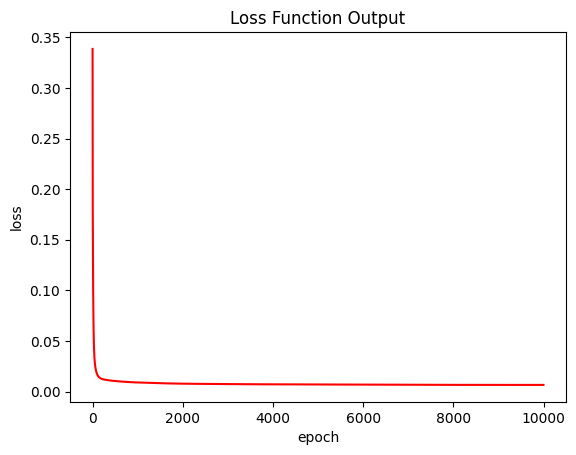

In [14]:
results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
results_train_loss[-1]

0.006585530936717987

#### Plot Trained Model Ouput

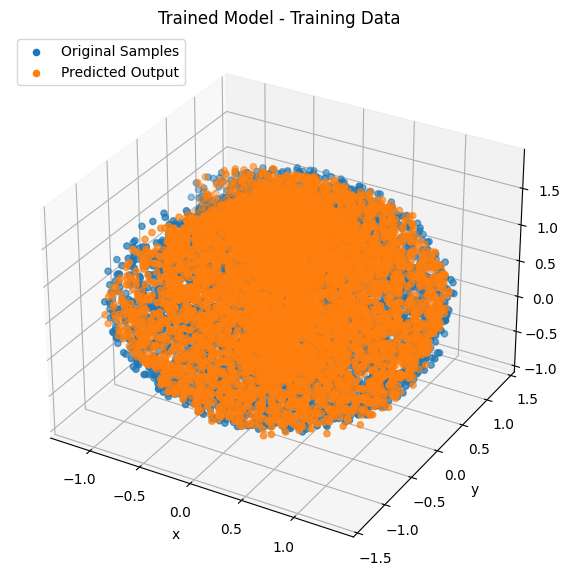

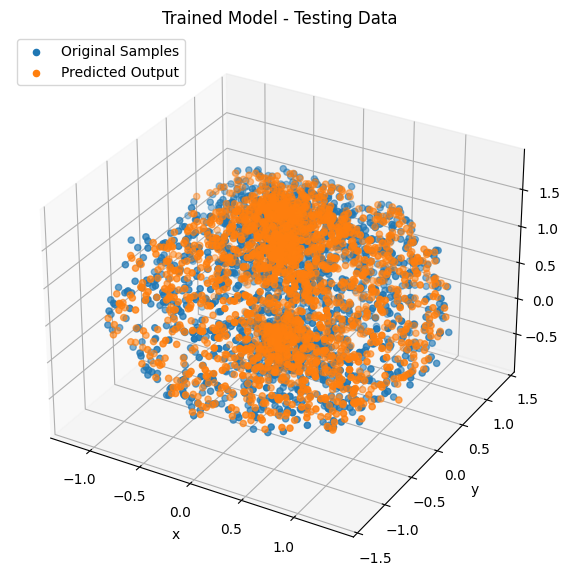

In [16]:
def plot_model(model, x_true, y_true, arg):
    y_predict = model_orig.predict(x_true)
    
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
 
    ## training output
    ax.scatter3D(y_true[:, 0], y_true[:, 1], y_true[:, 2], 'ro', label='Original Samples')

    ## predicted output
    ax.scatter3D(y_predict[:, 0], y_predict[:, 1], y_predict[:, 2], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    
    
    plt.xlim([np.min(y_train[:, 0]), np.max(y_train[:, 0])])
    plt.ylim([np.min(y_train[:, 1]), np.max(y_train[:, 1])])
    plt.show()
    
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, arg='Trained Model - Testing Data')

In [17]:
y_predict_train

array([[-0.09335452,  1.1775669 , -0.284582  ,  1.0044423 ],
       [-0.02749857, -0.1564605 , -0.05785236,  1.0019251 ],
       [-0.34384662,  0.43145323,  1.4200516 ,  0.99367267],
       ...,
       [ 0.03897992, -0.15181522, -0.3159642 ,  1.0007311 ],
       [-0.3454724 ,  0.15366402,  1.5188129 ,  0.98964596],
       [-0.1564683 ,  0.19023381,  1.6180509 ,  0.9920588 ]],
      dtype=float32)

In [18]:
my_data7 = genfromtxt('data7.csv', delimiter=',')

In [19]:
x_valid = my_data7[0:100,0:6]
y_valid = my_data7[0:100,6:]

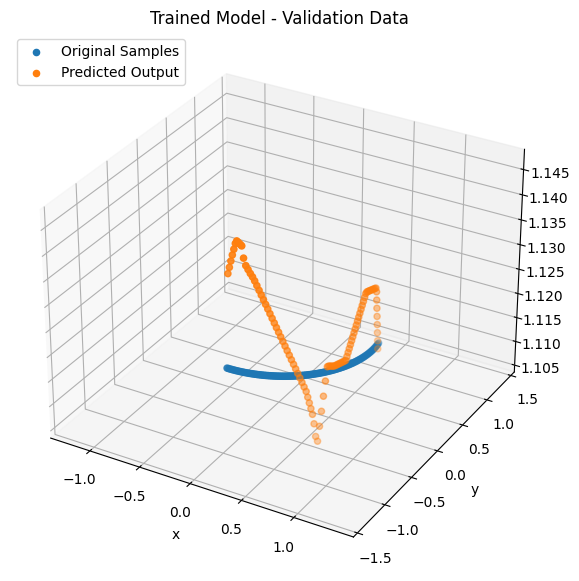

In [20]:
y_predict_valid = plot_model(model_orig, x_valid, y_valid, arg='Trained Model - Validation Data')


In [29]:
my_data10 = genfromtxt('data10.csv', delimiter=',')
x_valid = my_data10[201:500,0:6]
y_valid = my_data10[201:500,6:]

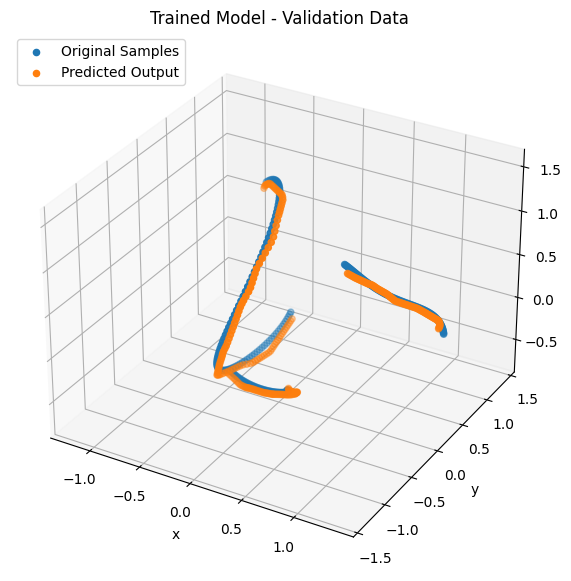

In [30]:
y_predict_valid = plot_model(model_orig, x_valid, y_valid, arg='Trained Model - Validation Data')

In [31]:
model_orig.save('model2\my_model_1')

INFO:tensorflow:Assets written to: model2\my_model_1\assets


In [32]:
import pickle

with open('model2\loss.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(his.history['loss'], filehandle)

In [33]:
with open('model2/x_train.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(x_train, filehandle)
    
with open('model2/y_train.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_train, filehandle)
    
with open('model2/x_test.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(x_test, filehandle)
    
with open('model2/y_test.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_test, filehandle)